# Workshop 05

- Name: Ran Arino
- Student ID: 153073200
- Email: rarino@myseneca.ca
- Course: Social Media Analytics
- Course ID: BDA600NAA.07578.2241
- Professor: Dr. Pantea Koochemeshkian

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter 
import re
import emoji
import nltk
from nltk.util import bigrams
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer


In [2]:
# re-use the function to clean the text data 
def clean_texts(raw_texts: list or np.array):
    # define result
    result = []

    # set of stopwords
    stop_words = set(stopwords.words('english'))
    # initialize tweet tokenizer
    tweet_tokenizer = TweetTokenizer()
    # set the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # function to convert emojis to text
    def convert_emojis(text):
        return emoji.demojize(text, delimiters=("", ""))
    
    # function to get the wordnet pos
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        else:
            # Default to noun
            return wordnet.NOUN

    # traversing all sentences
    for sent in raw_texts:
        # (0): convert to string
        sent = str(sent)
        # (1): white space removal
        sent = sent.strip()
        # (2): URL removal
        sent = re.sub(r"http[s]?://[\w?\W?]+", '', sent)
        # (3): HTML tag removal
        sent = re.sub(r'<[^>]+>', '', sent)
        # (4): Repeated words (at least four times)
        sent = re.sub(r'(.)\1{4,}', r'\1', sent)
        # (5): split attached words (at least two characters and follow the capitalized word)
        sent = re.sub(r"([\w]{2,})([A-Z])", r"\1 \2", sent)
        # (6): Punctuation removal
        sent = re.sub(r'[^\w\s]', '', sent)
        # (7): Emoji to text
        sent = convert_emojis(sent)
        # (8): lemmatizaiton & tokenization
        token = tweet_tokenizer.tokenize(sent)
        tagged_token = nltk.pos_tag(token)
        lemma_token = [
            lemmatizer.lemmatize(w[0], get_wordnet_pos(w[1]))
            for w in tagged_token
            # Only focusing on noun ('NN', 'NNP') at this time
            if w[1] in ['NN','NNP']
        ]
        # defined cleaned sentence
        clean_sent = ''
    
        # cleaning each sentence
        for w in lemma_token:
            # if 'w' is one of stop words, skip to the next word
            if w.lower() in stop_words:
                continue
            # add words
            clean_sent += w.lower() + ' '

        # add clean_sent to result (make sure that the last item is always blank)
        result += [clean_sent[:-1]]

    return result


In [3]:
# load data
df = pd.read_csv('data/Trumps_FB_Statuses.csv')

# extract only necessary data
df = df[['status_message', 'status_type', 'status_published', 'num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']]

# clean the status message
df.loc[:, 'clean_message'] = clean_texts(np.array(df['status_message'].values))

# ensure the dtype
df['status_type'] = df['status_type'].astype(str)
# convert a column to datetime format
df['status_published'] = pd.to_datetime(df['status_published'], errors='coerce', format='%m/%d/%Y %H:%M:%S')

df.head()

,status_message,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,clean_message
0,Beautiful evening in Wisconsin- THANK YOU for ...,photo,2016-10-17 20:56:51,6813.0,543.0,359.0,6178.0,572.0,39.0,17.0,0.0,7.0,evening wisconsin k yo u support everyone nove...
1,The State Department's quid pro quo scheme pro...,video,2016-10-17 18:00:41,33768.0,3644.0,17653.0,26649.0,487.0,1155.0,75.0,191.0,5211.0,state departments scheme corrup system crooked...
2,Crooked Hillary's State Department colluded wi...,video,2016-10-17 15:34:46,85627.0,8810.0,32594.0,73519.0,2943.0,1020.0,330.0,263.0,7552.0,hillarys state department fb j disgracefu l ex...
3,"JournoCash: Media gives $382,000 to Clinton, $...",link,2016-10-17 14:17:24,22696.0,3665.0,5082.0,14029.0,122.0,2091.0,241.0,286.0,5927.0,journo cash media clinton trump margin
4,"Exclusive: ""O'Keefe Video Sting Exposes 'Bird-...",link,2016-10-17 12:03:19,40729.0,4905.0,17087.0,26472.0,178.0,2588.0,154.0,417.0,10922.0,okeefe video sting exposes birddogging effort ...


Text(0.5, 1.0, 'Distribution of Statuses Types')

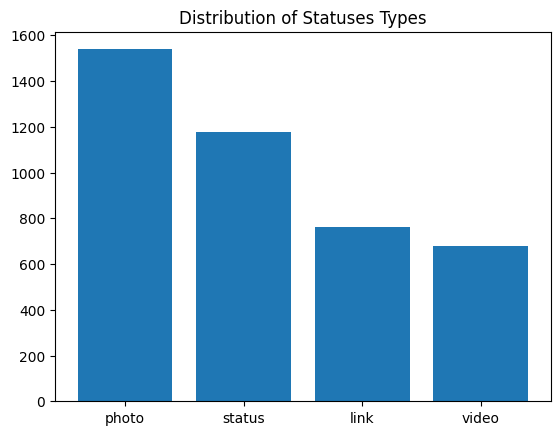

In [4]:
# plot the distribution of types of statuses (only top four categories)

#  list of xaxis categories
x = list(df['status_type'].value_counts().index)[:4]

#  list of yaxis data
y = list(df['status_type'].value_counts())[:4]


plt.bar(x, y)
plt.title('Distribution of Statuses Types')

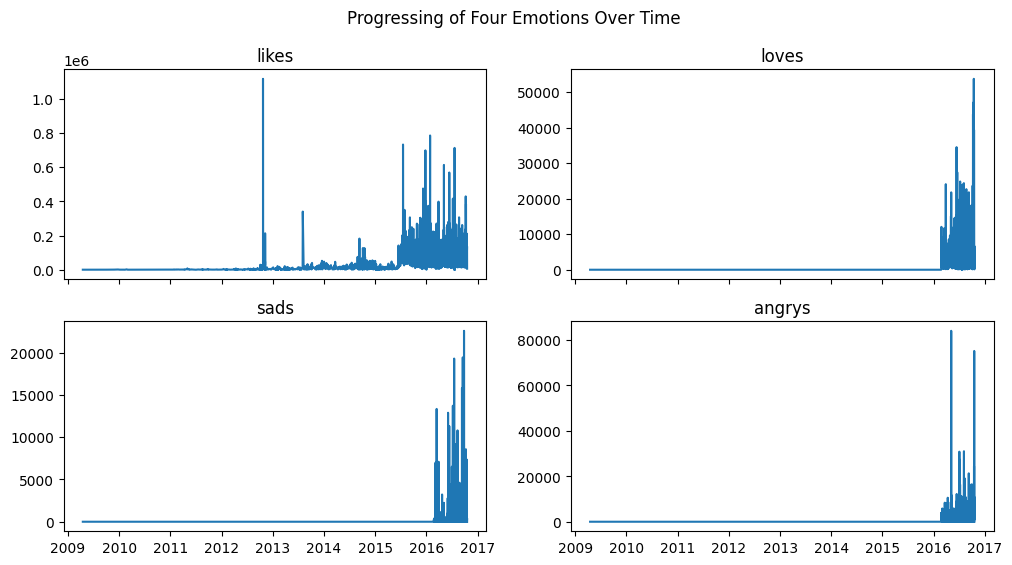

In [5]:
# define column names for four emotions
data = ['num_likes', 'num_loves', 'num_sads', 'num_angrys']
fig, ax = plt.subplots(nrows=2, ncols=2, sharex='all', figsize=(12, 6))
fig.suptitle('Progressing of Four Emotions Over Time')

for i, d in enumerate(data):
    ax[i//2][i%2].plot(df['status_published'], df[d])
    ax[i//2][i%2].set_title(f'{d.split("_")[1]}')


# Observations
# - Donald Trump got attention hugely at the end of 2012 and 2013, also after the middle of 2015.
# - the functionalities of 'loves', 'sads', and 'angrus' seem to be implemented after the beginning of 2016.

Text(0.5, 1.0, 'Top Reactions')

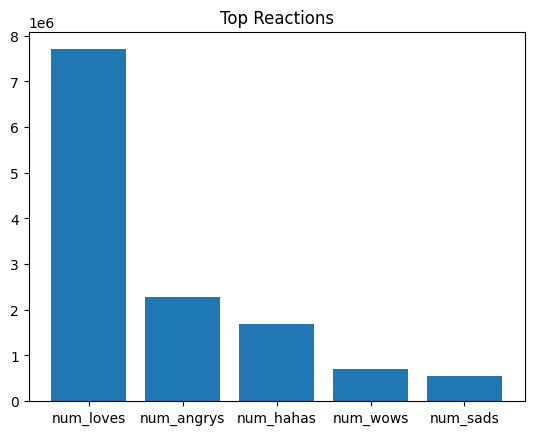

In [6]:
# define reactions
#  at this time, the number of 'likes' are removed from the following list;
#  because the other reactions launched at different time. 
reactions = ['num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
total_reactions = df[reactions].sum().sort_values(ascending=False)

# show bar plot
plt.bar(total_reactions.index, total_reactions.values)
plt.title("Top Reactions")

# Observations:
# - The following result shows that Donald Trump acquired the 'love' reaction (maybe, heart mark or emoji) from Facebook users.
# - Although some people showed 'angrys' reactions, it can infer that the majority of people on Facebook were in favor of Donald Trump. 

Text(0.5, 1.0, 'Top 10 bigrams')

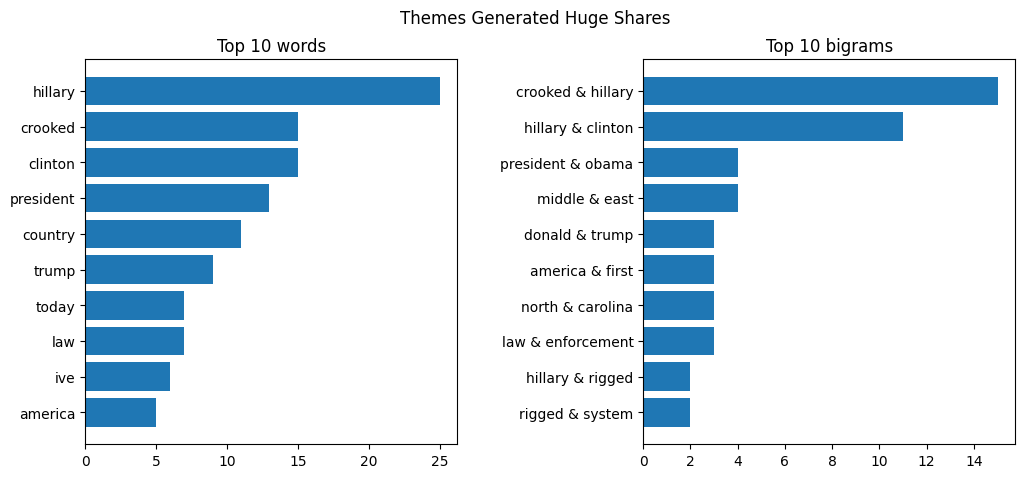

In [8]:
# get message based on the top 50 shares
top_share = df[['num_shares', 'clean_message']].sort_values(by='num_shares', ascending=False).reset_index(drop=True).iloc[:50]
# list of all words and bigrams from the entire messages
all_words = [word for word in " ".join(top_share['clean_message'].values).split(' ') if len(word) > 1]
all_bigram = bigrams(all_words)

# couting the frequency
word_counts = Counter(all_words)
bigram_counts = Counter(all_bigram)

# get the top 10 words and bigrams
top10_words = sorted(word_counts, key=word_counts.get, reverse=True)[:10]
top10_bigrams= sorted(bigram_counts, key=bigram_counts.get, reverse=True)[:10]

# show the frequency on each word and bigram
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Themes Generated Huge Shares")
plt.subplots_adjust(wspace=0.5)
ax[0].barh(top10_words[::-1], [word_counts[w] for w in top10_words[::-1]])
ax[0].set_title('Top 10 words')
ax[1].barh([f"{a} & {b}" for a, b in top10_bigrams[::-1]], [bigram_counts[w] for w in top10_bigrams[::-1]])
ax[1].set_title('Top 10 bigrams')

# Observation:
#  The results shows that the following topics were likely to be shared widely on Facebook in terms of Donald Trump; 
#  Criticism for Hillary Clinton, Remarks related to President Obama, Strong posture for world situation, and Emphasize for America First.

Text(0.5, 1.0, 'Top 10 bigrams')

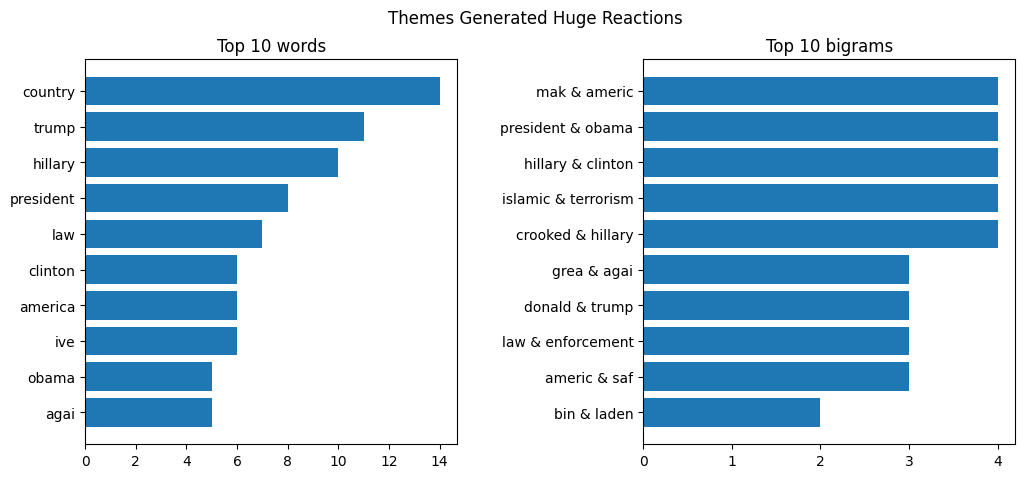

In [10]:
# get message based on the top 50 shares
top_react = df[['num_reactions', 'clean_message']].sort_values(by='num_reactions', ascending=False).reset_index(drop=True).iloc[:50]
# list of all words and bigrams from the entire messages
all_words = [word for word in " ".join(top_react['clean_message'].values).split(' ') if len(word) > 1]
all_bigram = bigrams(all_words)

# couting the frequency
word_counts = Counter(all_words)
bigram_counts = Counter(all_bigram)

# get the top 10 words and bigrams
top10_words = sorted(word_counts, key=word_counts.get, reverse=True)[:10]
top10_bigrams= sorted(bigram_counts, key=bigram_counts.get, reverse=True)[:10]

# show the frequency on each word and bigram
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Themes Generated Huge Reactions")
plt.subplots_adjust(wspace=0.5)
ax[0].barh(top10_words[::-1], [word_counts[w] for w in top10_words[::-1]])
ax[0].set_title('Top 10 words')
ax[1].barh([f"{a} & {b}" for a, b in top10_bigrams[::-1]], [bigram_counts[w] for w in top10_bigrams[::-1]])
ax[1].set_title('Top 10 bigrams')

# Observation:
#  The results shows that the following topics were likely to get larger reactions on Facebook in terms of Donald Trump; 
#  Criticism for Hillary Clinton, Emphasize for America First(including protection of country), A strong stance against terrorism and legal enforcement.